In [3]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns

import esm

import sys, os, math

sys.path.insert(0, '../dlp')
from data_process import *

In [24]:
def esm_hierarchy_data_to_tensor_batch_(split, i):
    sequences, lineage_str, sequence_strs = torch.load(f'../embeddings/esm_embeddings/{split}/{i}.pt')

    tax_ids = [encode_lineage(s) for s in lineage_str]

    combined_dict = {}
    for d in tax_ids:
        for key, value in d.items():
            combined_dict.setdefault(key, []).extend(value)

    tensor_encoded = {k: torch.LongTensor(v) for k,v in combined_dict.items()}
    return Batch(sequences[0], tensor_encoded), sequence_strs

In [25]:
tensor_batch, sequences = esm_hierarchy_data_to_tensor_batch_('train', 0)
# print(tensor_batch)
# print(sequences)
print(tensor_batch.seq_ids.shape)
print(tensor_batch.taxes["begining root"].tolist())
print(sequences)

torch.Size([16, 1000, 320])
[2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
['MSLYHETAEILSASPDHGGSLKSRVFGKKGLKSPPAQVYALALETCKWSGVLKEVVEAAEILRHERKLTPVLALLLVHDFLLAKKGIALPQTHGLRTSVERHKARLASELTRARLRRKMPSVEALRADVNANADPEGRHPRWIRVNALRSNVEDQLETTFKGWERALSIEAVTQSAGKAIFIDTHVPNLLAAPPGTDVTKTPAYLKGEIILQDKASCFPAYLLDPRSEDGDVVDSCAAPGNKTTHLAAIVQSHQPDQTTRQPTIFAFERDPRRAQTLEKMVKIAGSRGMTKIGPGQDFLDVDPEADAYKHVGALLLDPSCSGSGIVGRDSMPELHLPELPGPAAAAAKGAKGAKGKADRLKRKRAEEERPVMVDDDGNAVEVQSEQELQKRLDALAGFQLTLLLHAMRFSSATKITYSTCSIHAEENEGVVVRALASTVAKARGWRVLAREKQVRGMREWPVRGLPEAAGGDAAVAEACIRTYKGDGHGVMGFFVAAFARDGGEGAAAGEDGPYVRDDEGRIVRDAAGMPVLKSTGEPVVLEDAARQAPPGGGDDSEDDSEGSSEHGSDEDEWAGFD', 'MRGQKRRAFRSTGRQHGTRRQILPAAVAMTVGLMTPLALVPPAASAAGPDAVQQSLNALVRDIGTPAALASVEDREGRARTYTAGVGDLTTGAKVPRDGQVRIGSNTKTFVAVVVLQLVAERRMSLDAFVDTYLPGLVRGKGIDGRRITVRQLLQHTSGLPEYTSHLGDDARYYAPRELLATALRHPADFDPGKSWKYSNTNYVLAGLIVQKVTARPLADEIDRRVIKRIGLRHTYFPAPGDASIREPHPHGYYQESTQTPLRDITEVDPSWGWAAGQMISTNSDLNRFFTALLAGRLIPPAQLAQMRTTVPAEATFGPGARYGLGLVSRPLPCSGLSWG

In [26]:
max_seq_len = 1000
max_tax_len = 150

# Character vocabulary for protein sequences (20 amino acids + 1 padding)
vocab = "ACDEFGHIKLMNPQRSTVWY"
char_to_idx = {char: idx + 1 for idx, char in enumerate(vocab)}  # Start index from 1 for padding
# Sequence encoder: Convert the protein sequence into integers
def encode_sequence(sequence):
    return [char_to_idx.get(char, 0) for char in sequence] + [0 for _ in range(max_seq_len - len(sequence))]  # 0 for unknown characters or padding 

In [33]:
ys = []
Xs = []

for i in range(1_000):
    # print(i)
    tensor_batch, sequences = esm_hierarchy_data_to_tensor_batch_('train', i)
    Xs.extend([encode_sequence(s)for s in sequences])
    ys.extend(tensor_batch.taxes["begining root"].tolist())

Xs = torch.Tensor(Xs).numpy()
print(len(ys))
print(Xs.shape)

16000
(16000, 1000)


In [55]:
ys = np.array(ys)
indices = np.where(ys == 3)
Xs_selected = Xs[indices]

In [13]:
ys = []
Xs = []

for i in range(1_000):
    # print(i)
    tensor_batch, _ = esm_hierarchy_data_to_tensor_batch('train', i)
    Xs.append(tensor_batch.seq_ids.mean(dim=1))
    ys.extend(tensor_batch.taxes["begining root"].tolist())

Xs_ESM = torch.concat(Xs, dim=0).numpy()
print(len(ys))
print(Xs.shape)

16000
(16000, 320)


In [44]:
from sklearn.decomposition import PCA

num_pca_components = 30
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs)
# Xs_ESM_pca = pca.fit_transform(Xs_ESM)

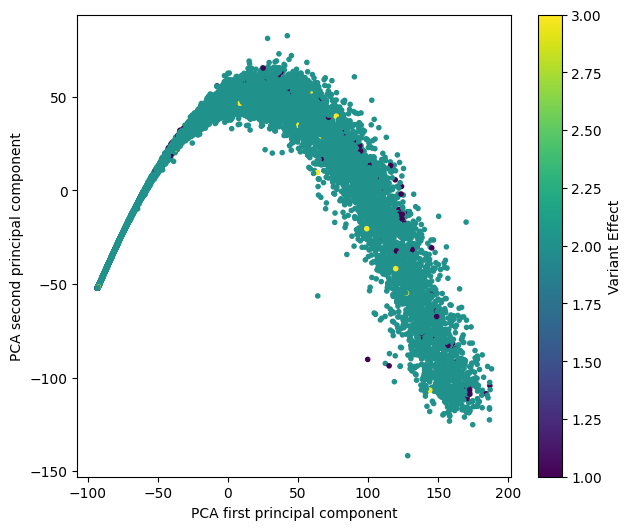

In [59]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
# plt.legend()
plt.colorbar(sc, label='Variant Effect')

In [57]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.pipeline import Pipeline

In [18]:
knn_grid = [
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [5, 10],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size' : [15, 30],
        'model__p' : [1, 2],
    }
    ]

svm_grid = [
    {
        'model': [SVR()],
        'model__C' : [0.1, 1.0, 10.0],
        'model__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__degree' : [3],
        'model__gamma': ['scale'],
    }
]

rfr_grid = [
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators' : [20],
        'model__criterion' : ['squared_error', 'absolute_error'],
        'model__max_features': ['sqrt', 'log2'],
        'model__min_samples_split' : [5, 10],
        'model__min_samples_leaf': [1, 4]
    }
]

In [19]:
cls_list = [KNeighborsRegressor, SVR, RandomForestRegressor]
param_grid_list = [knn_grid, svm_grid, rfr_grid]

In [21]:
from sklearn.model_selection import GridSearchCV

# make sure data preprocessing (PCA here) is run inside CV to avoid data leakage
pipe = Pipeline(
    steps = (
        ('pca', PCA(num_pca_components)),
        ('model', 'passthrough')
    )
)

result_list = []
grid_list = []
for cls_name, param_grid in zip(cls_list, param_grid_list):
    print(cls_name)
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        scoring = 'r2',
        verbose = 1,
        n_jobs = -1 # use all available cores
    )
    grid.fit(Xs, ys)
    result_list.append(pd.DataFrame.from_dict(grid.cv_results_))
    grid_list.append(grid)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 370, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2145, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline

<class 'sklearn.svm._classes.SVR'>
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 370, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2145, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 370, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "/opt/conda/envs/py_3.10/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2145, in _check_response_method
    raise AttributeError(
AttributeError: Pipeline

In [22]:
result_list[0].sort_values('rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__algorithm,param_model__leaf_size,param_model__n_neighbors,param_model__p,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.068752,0.028325,0.001263,0.000274,KNeighborsRegressor(),ball_tree,15,5,1,uniform,"{'model': KNeighborsRegressor(), 'model__algor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
26,0.062203,0.004409,0.000402,0.000068,KNeighborsRegressor(),kd_tree,30,5,2,uniform,"{'model': KNeighborsRegressor(), 'model__algor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
27,0.055406,0.003186,0.000396,0.000034,KNeighborsRegressor(),kd_tree,30,5,2,distance,"{'model': KNeighborsRegressor(), 'model__algor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
28,0.055654,0.003816,0.000375,0.000110,KNeighborsRegressor(),kd_tree,30,10,1,uniform,"{'model': KNeighborsRegressor(), 'model__algor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
29,0.056124,0.005079,0.000451,0.000071,KNeighborsRegressor(),kd_tree,30,10,1,distance,"{'model': KNeighborsRegressor(), 'model__algor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
0